## Imports

In [1]:
path = "../Data"
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pmp_functions as pmp
%matplotlib inline
plt.style.use('bmh')
plt.rcParams.update({
    "font.family": "serif",
    "grid.linestyle": "--",
    "font.size": 10,
    "grid.linewidth": 0.5,
    "grid.alpha": 0.7,
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "savefig.facecolor": "white"
})

## Data

In [2]:
LTG = pd.read_csv(f"{path}/LTG_AGG.csv", parse_dates=["DATE"], index_col="DATE")
prices = pd.read_excel(f"{path}/Futures.xlsx", parse_dates=["Date"], index_col="Date")
benchmarks = pd.read_excel(f"{path}/Benchmarks.xlsx", parse_dates=["Date"], index_col="Date")
factor_data = pd.read_csv(f"{path}/famafrench_factors_global.csv", parse_dates=["DATE"], index_col="DATE")


C:\Users\mgrue\AppData\Local\Temp\ipykernel_32140\2219535233.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  factor_data = pd.read_csv(f"{path}/famafrench_factors_global.csv", parse_dates=["DATE"], index_col="DATE")


In [3]:
prices.head()

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1970-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
first_valid_dates = {
    "CH": "1994-12",
    "US": "1981-12",
    "EM": "1995-01",
    "AU": "1988-05",
    "EU": "1987-01",
    "JP": "1987-01",
    "UK": "1987-01"
}

for region, start in first_valid_dates.items():
    LTG.loc[LTG.index < pd.to_datetime(start), region] = np.nan

In [5]:
LTG = LTG.reindex(prices.index, method="ffill")
LTG = LTG.dropna(how="all")
LTG.tail()

,CH,AU,US,JP,EU,EM,UK
Date,,,,,,,
2025-06-30,0.099503,0.086050,0.102968,0.092311,0.102488,0.133313,0.092826
2025-07-31,0.096864,0.095327,0.102352,0.092261,0.097528,0.129584,0.090257
2025-08-29,0.101678,0.090657,0.102221,0.095678,0.099937,0.134945,0.091813
2025-09-30,0.093856,0.099322,0.101758,0.095591,0.099594,0.137976,0.089405
2025-10-31,0.093856,0.099322,0.101758,0.095591,0.099594,0.137976,0.089405


In [6]:
factors = pd.read_csv(f"{path}/Factors.csv")
factors["Date"] = pd.to_datetime(factors["Date"].astype(str) + "01", format="%Y%m%d") + pd.offsets.MonthEnd(0)
factors.set_index("Date", inplace=True)
factors = factors / 100

RF = factors["RF"]
RF = RF.reindex(prices.index, method="ffill")
RF.to_frame().head()

,RF
Date,
1970-01-30,0.0064
1970-02-27,0.0060
1970-03-31,0.0057
1970-04-30,0.0050
1970-05-29,0.0050


## Global Variables

In [7]:
frequency = 1
t_cost  = 0.0002
k = 2
weights_lag = 0
window = 12*20
short = True
beta_neutral = False
min_regions = 4

## Signal Creation

In [8]:
def expanding_rolling_df(df, window):
    out = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)
    for col in df.columns:
        series = df[col]
        values = []
        for i in range(len(series)):
            start = max(0, i - window + 1)
            values.append(series.iloc[start:i+1].mean())
        out[col] = values
    return out

In [9]:
ltg = LTG.copy()


#ltg_avg = expanding_rolling_df(ltg, window).shift(1)
ltg_avg = ltg.expanding().mean().shift(1)

ltg_signal = ltg_avg / ltg
ltg_signal.tail()

,CH,AU,US,JP,EU,EM,UK
Date,,,,,,,
2025-06-30,1.022813,1.123556,1.374791,1.099815,1.000482,1.119892,1.029268
2025-07-31,1.050614,1.013967,1.382341,1.100190,1.051362,1.151781,1.058499
2025-08-29,1.000747,1.066166,1.383390,1.060691,1.025902,1.105622,1.040440
2025-09-30,1.084145,0.973021,1.388956,1.061531,1.029381,1.081057,1.068376
2025-10-31,1.083917,0.973081,1.388216,1.061398,1.029317,1.080837,1.068229


In [10]:
returns_unhedged = prices.pct_change()
rename_map = {
    "EEM US Equity": "EM",
    "EZU US Equity": "EU",
    "EWA US Equity": "AU",
    "EWJ US Equity": "JP",
    "EWL US Equity": "CH",
    "WFSPX US Equity": "US",
    "EWU US Equity": "UK",
}

returns_unhedged = returns_unhedged.rename(columns=rename_map)
returns_unhedged.head()

,US,AU,CH,JP,UK,EM,EU
Date,,,,,,,
1970-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1970-05-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
benchmark = benchmarks["MSCI World"].pct_change()
benchmark

Date
1986-12-31         NaN
1987-01-30         NaN
1987-02-27         NaN
1987-03-31         NaN
1987-04-30         NaN
                ...   
2025-07-31    0.013121
2025-08-29    0.026408
2025-09-30    0.032574
2025-10-31    0.020226
2025-11-28    0.003149
Name: MSCI World, Length: 468, dtype: float64

In [12]:
ltg_signal.head()

,CH,AU,US,JP,EU,EM,UK
Date,,,,,,,
1981-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982-01-29,NaN,NaN,0.973928,NaN,NaN,NaN,NaN
1982-02-26,NaN,NaN,1.013973,NaN,NaN,NaN,NaN
1982-03-31,NaN,NaN,0.988631,NaN,NaN,NaN,NaN
1982-04-30,NaN,NaN,1.009551,NaN,NaN,NaN,NaN


In [13]:
weights = pmp.make_country_weights(
    ltg_signal,
    returns_unhedged,
    benchmark_series=benchmark,
    k=k,
    long_short=short,
    signal_lag=weights_lag,
    min_regions=min_regions,
    beta_neutral=beta_neutral,
    beta_window=12,
)

In [14]:
weights = pmp.append_final_zero_row(weights, "2025-10-31")
weights.tail()

,CH,AU,US,JP,EU,EM,UK
2025-06-30,-0.5,0.5,0.5,0.0,-0.5,0.0,0.0
2025-07-31,-0.5,-0.5,0.5,0.0,0.0,0.5,0.0
2025-08-29,-0.5,0.0,0.5,0.0,-0.5,0.5,0.0
2025-09-30,0.5,-0.5,0.5,0.0,-0.5,0.0,0.0
2025-10-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Buckets

In [15]:
def plot_3buckets(bucket_returns):
    cum = (1 + bucket_returns).cumprod()

    plt.figure(figsize=(12,6))
    for col in cum.columns:
        plt.plot(cum.index, cum[col], label=col)

    plt.title("Dynamic LTG 3-Bucket Performance (Top–Middle–Bottom)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("Figures/LTG-Buckets.png")
    plt.show()

In [16]:
#ranks, bucket_returns = pmp.ltg_3bucket_dynamic(ltg_signal, returns_unhedged)
#plot_3buckets(bucket_returns)

## Backtest

In [17]:
results = pmp.run_cc_strategy(
    weights=weights,
    returns=returns_unhedged,
    rf=RF,
    frequency=frequency,
    t_cost=t_cost,
    benchmark= benchmark,
    long_short=short,
    beta_neutral=beta_neutral
)

In [18]:
results.head()

,ret_net,ret_gross,ret_bm,turnover,tcost,ret_rf,w_CH,w_AU,w_US,w_JP,w_EU,w_EM,w_UK
Date,,,,,,,,,,,,,
1998-10-30,-0.009696,-0.009696,0.089894,0.000000,0.000000e+00,0.0046,-0.518022,0.0,-0.481978,0.526041,0.0,0.0,0.473959
1998-11-30,-0.007911,-0.007902,0.059518,0.044063,8.812632e-06,0.0031,-0.499272,0.0,-0.500728,0.498878,0.0,0.0,0.501122
1998-12-31,-0.027731,-0.027730,0.048630,0.001850,3.700482e-07,0.0038,-0.489138,0.0,-0.510862,0.499406,0.0,0.0,0.500594
1999-01-29,0.013651,0.013654,0.021329,0.011456,2.291212e-06,0.0038,-0.489197,0.0,-0.510803,0.510044,0.0,0.0,0.489956
1999-02-26,0.027041,0.027045,-0.026713,0.020847,4.169444e-06,0.0035,-0.498452,0.0,-0.501548,0.487403,0.0,0.0,0.512597


## Performance Statistics

In [19]:
pmp.run_perf_summary_benchmark_vs_strategy(results, alreadyXs=True)

,Benchmark,Strategy
Arithm Avg Total Return,9.1838,7.1536
Arithm Avg Xs Return,7.2033,5.1730
Std Xs Returns,15.3886,9.6653
Sharpe Arithmetic,0.4681,0.5352
Geom Avg Total Return,8.2884,6.8997
Geom Avg Xs Return,6.2915,4.9027
Sharpe Geometric,0.4088,0.5073
Min Xs Return,-19.0140,-8.1292
Max Xs Return,12.8184,11.3333
Skewness,-0.5694,0.3110


In [20]:
#factor_data = factor_data[["MKT-RF", "SMB", "HML", "UMD", "BAB"]]
pmp.run_factor_regression(results, factor_data, alreadyXs=True)

,Strategy
Arithm Avg Total Return,7.1536
Arithm Avg Xs Return,5.1730
Std Xs Returns,9.6653
Sharpe Arithmetic,0.5352
Geom Avg Total Return,6.8997
Geom Avg Xs Return,4.9027
Sharpe Geometric,0.5073
Min Xs Return,-8.1292
Max Xs Return,11.3333
Skewness,0.3110


In [21]:
import edhec_risk_kit as edh
edh.drawdown(results["ret_net"]).min()

Wealth      955.225034
Peaks       990.303645
Drawdown     -0.182551
dtype: float64

In [22]:
edh.drawdown(results["ret_bm"]).min()

Wealth       827.813938
Peaks       1089.894022
Drawdown      -0.535898
dtype: float64

In [23]:
turnover_annualized = results["turnover"].mean() * 12 * 100
turnover_annualized

313.61925852364186

In [24]:
turnover_monthly = results["turnover"].mean()
turnover_annualized = turnover_monthly * 12

# Holding Period (in Jahren)
holding_period_years = 1 / turnover_annualized

# Holding Period (in Monaten)
holding_period_months = holding_period_years * 12

holding_period_years, holding_period_months

(0.31885796959902446, 3.8262956351882935)

## Plots

In [25]:
factor_data

,MKT-RF,SMB,HML,UMD,BAB,RMW,CMA
DATE,,,,,,,
1990-11-30,-0.0372,0.0143,0.0113,0.0014,-0.0835,0.0131,-0.0212
1990-12-31,0.0111,-0.0074,-0.0147,-0.0264,-0.0284,0.0138,-0.0033
1991-01-31,0.0249,-0.0187,0.0047,-0.0169,-0.1145,0.0094,-0.0221
1991-02-28,0.0903,0.0246,0.0003,-0.0745,-0.0359,-0.0200,-0.0030
1991-03-31,-0.0229,0.0328,-0.0105,0.0195,-0.0341,0.0075,-0.0127
...,...,...,...,...,...,...,...
2025-06-30,0.0410,0.0048,0.0001,-0.0100,-0.0246,-0.0130,0.0008
2025-07-31,0.0068,-0.0044,-0.0010,-0.0020,-0.0842,0.0015,-0.0118
2025-08-31,0.0264,0.0252,0.0288,-0.0211,0.0391,-0.0129,0.0182


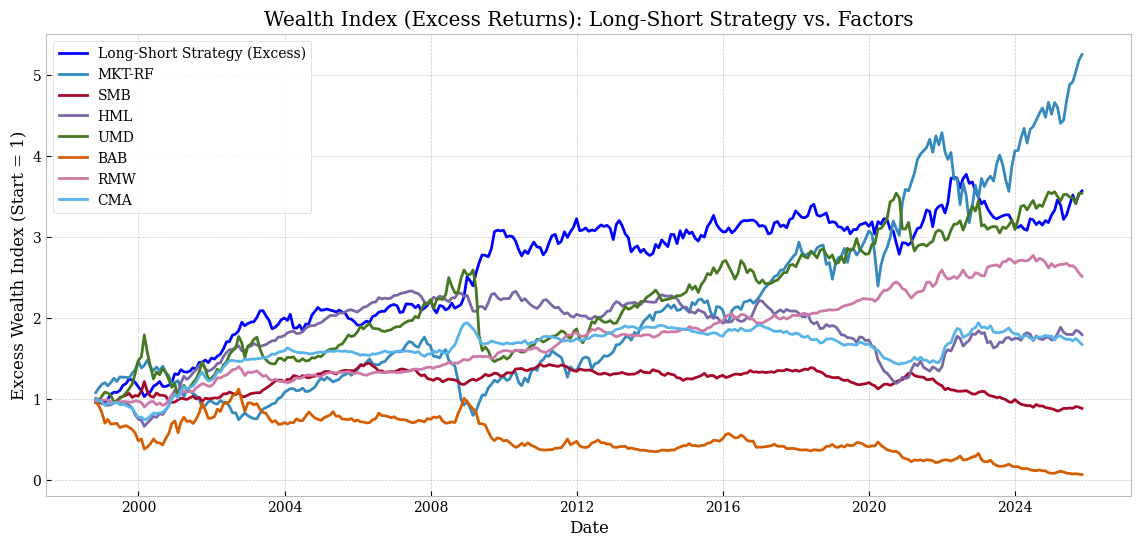

In [26]:
plt.figure(figsize=(14, 6))

# --- Strategy Excess Wealth ---
strategy = (1 + results["ret_net"]).cumprod()

# Startdatum bestimmen
start_date = strategy.first_valid_index()

# --- Faktor-Daten auf denselben Zeitraum trimmen ---
factors = factor_data.loc[start_date:].copy()

# --- Strategy plotten ---
plt.plot(
    strategy.loc[start_date:],
    label="Long-Short Strategy (Excess)",
    color="blue"
)

# --- Faktoren plotten (identisches Design, nur getrimmt) ---
for col in factors.columns:
    plt.plot(
        (1 + factors[col]).cumprod(),
        label=col
    )

plt.title("Wealth Index (Excess Returns): Long-Short Strategy vs. Factors")
plt.xlabel("Date")
plt.ylabel("Excess Wealth Index (Start = 1)")
# plt.yscale("log")  # falls du log willst
plt.legend()
plt.grid(True)

plt.savefig("Figures/CC_LS_Excess_Cum.png", bbox_inches="tight")
plt.show()


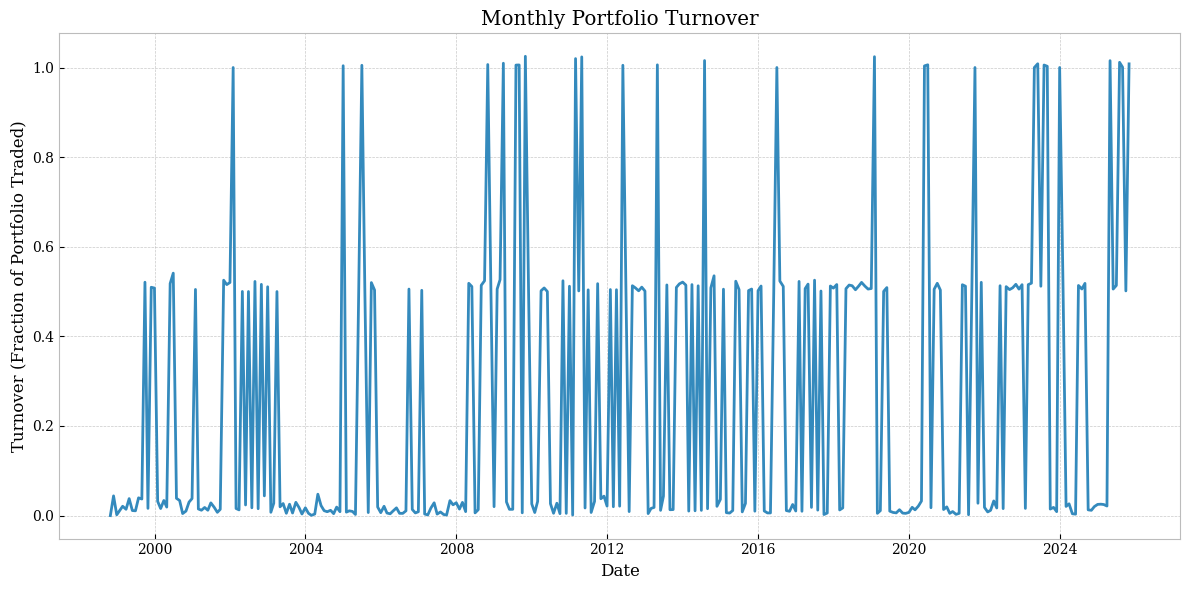

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(results["turnover"], label="Portfolio Turnover")

plt.title("Monthly Portfolio Turnover")
plt.xlabel("Date")
plt.ylabel("Turnover (Fraction of Portfolio Traded)")

plt.grid(True)
plt.tight_layout()
plt.savefig("Figures/CC_LS_Unhedged_Turnover.png", bbox_inches="tight")
plt.show()


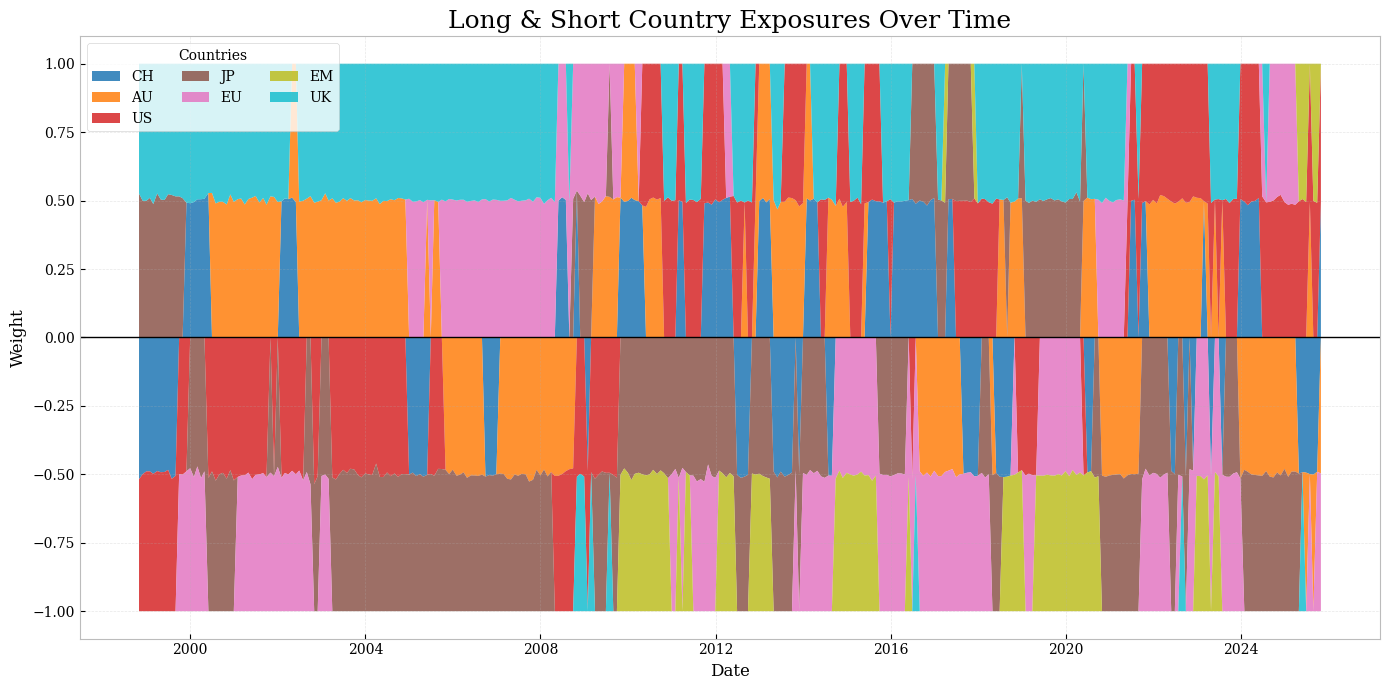

In [28]:
import matplotlib.pyplot as plt
import numpy as np

weight_cols = [col for col in results.columns if col.startswith("w_")]
weights = results[weight_cols].copy()
weights.columns = [col.replace("w_", "") for col in weight_cols]

long_weights = weights.clip(lower=0)
short_weights = weights.clip(upper=0).abs()

regions = weights.columns

# ---- Saturated Color Palette ----
colors = plt.cm.tab10(np.linspace(0, 1, len(regions)))
color_map = {region: colors[i] for i, region in enumerate(regions)}

plt.figure(figsize=(14, 7))

# ---- LONG stack ----
plt.stackplot(
    long_weights.index,
    long_weights.T,
    labels=regions,
    colors=[color_map[r] for r in regions],
    alpha=0.85
)

# ---- SHORT stack ----
plt.stackplot(
    short_weights.index,
    -short_weights.T,
    colors=[color_map[r] for r in regions],
    alpha=0.85
)

plt.axhline(0, color="black", linewidth=1)
plt.title("Long & Short Country Exposures Over Time", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Weight")
plt.grid(alpha=0.3)

plt.legend(title="Countries", loc="upper left", ncol=3)
plt.tight_layout()
plt.savefig("Figures/CC_LS_Unhedged_Exposure.png", bbox_inches="tight")
plt.show()
